In [2]:
#%pip install cupy-cuda11x

import matplotlib.pyplot as plt
import numpy as np
from numba import njit, jit, prange, complex64, vectorize, cuda
import cupy as cp

In [3]:
@njit
def Diag(kx, ky):
  t = 3.3
  a = 1
  H = np.zeros((6, 6), dtype = complex64)

  gammaAB = np.exp(1j*kx*a*np.sqrt(3)/2)*np.exp(1j*ky*a/2)
  gammaAF = np.exp(-1j*kx*a*np.sqrt(3)/2)*np.exp(1j*ky*a/2)
  gammaAD = np.exp(-1j*ky*a)
  gammaBC = np.exp(1j*ky*a)
  gammaBF = np.exp(1j*kx*a)
  gammaCD = np.exp(-1j*kx*a*np.sqrt(3)/2)*np.exp(1j*ky*a/2)
  gammaCE = np.exp(1j*kx*a)
  gammaDE = np.exp(-1j*kx*a*np.sqrt(3)/2)*np.exp(-1j*ky*a/2)
  gammaEF = np.exp(-1j*ky*a)

  H[0, 1] = -t*gammaAB
  H[0, 3] = -t*gammaAD
  H[0, 5] = -t*gammaAF
  H[1, 2] = -t*gammaBC
  H[1, 5] = -t*gammaBF
  H[2, 3] = -t*gammaCD
  H[2, 4] = -t*gammaCE
  H[3, 4] = -t*gammaDE
  H[4, 5] = -t*gammaEF
  H[0, 0] = H[3, 3] = -2.2/2
  H[1, 1] = H[2, 2] = H[4, 4] = H[5, 5] = -1.85/2


  H = H + np.transpose(np.conjugate(H))

  return np.linalg.eigvalsh(H)

In [23]:
Nk = 1000

b1 = 2*np.pi/3
b2 = 2*np.pi/(1+np.sqrt(3))

GammaX = np.linspace(0, b1, Nk) #ky = 0
XS = np.linspace(0, b2, Nk) #kx = b1
SY = np.linspace(b1, 0, Nk) #ky = b2
YGamma = np.linspace(b2, 0, Nk) #kx = 0

print(b1)
print(b2, '\n')
#print(GammaX)
#print(XS)
#print(SY)

N = int(1.4*len(GammaX))

kx1 = np.linspace(0, b1, N)
ky1 = np.linspace(0, b2, N)

path1 = np.zeros((6, len(GammaX)))
path2 = np.zeros((6, len(XS)))
path3 = np.zeros((6, len(SY)))
path4 = np.zeros((6, len(YGamma)))

path5 = np.zeros((6, N))

for i in range(len(GammaX)):
  path1[:, i] = Diag(GammaX[i], 0)

for i in range(len(XS)):
  path2[:, i] = Diag(b1, XS[i])

for i in range(len(SY)):
  path3[:, i] = Diag(SY[i], b2)

for i in range(len(YGamma)):
  path4[:, i] = Diag(0, YGamma[i])

for i in range(N):
  path5[:, i] = Diag(kx1[i], ky1[i])


l = 2*np.pi*(2/3 + 2/(1+np.sqrt(3)) + np.sqrt(1/9 + 1/(4+2*np.sqrt(3))))

bands = np.concatenate((path1, path2, path3, path4, path5), axis = 1)
total_path = np.linspace(0, l, len(bands[0, :]))
#GammaS

2.0943951023931953
2.2998054391128604 



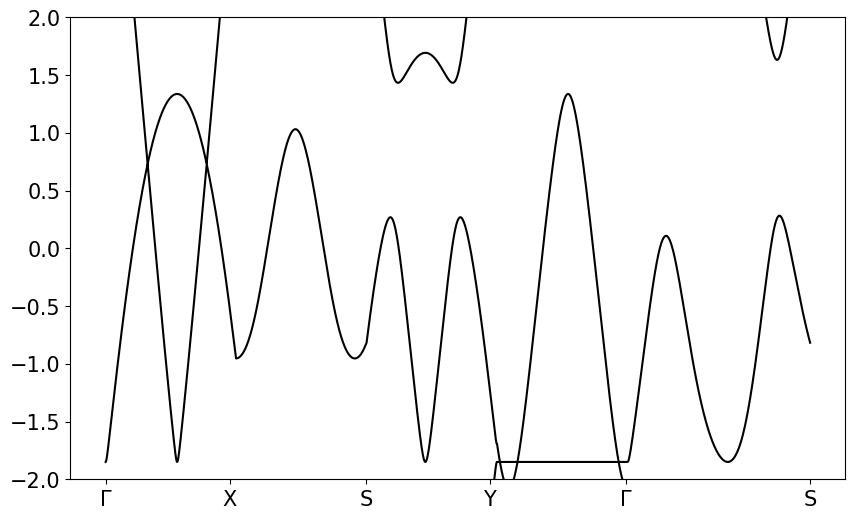

In [24]:
fig = plt.figure(figsize = (10, 6))

for i in range(6):
  plt.plot(total_path, bands[i], color = 'black')

plt.xticks([0, b1, b1+b2, 2*b1+b2, 2*(b1+b2), total_path[-1]], [r'$\Gamma$', 'X', 'S', 'Y', r'$\Gamma$', 'S'])
plt.tick_params(labelsize = 15)

plt.ylim(-2, 2)

plt.show()

In [63]:

@njit
def delta(om, en):
  eta = 0.01
  return (1/np.pi)*eta/(eta**2 + (om-en)**2)

In [64]:
@njit(parallel = True)
def Density(om_low_, om_high_, n_, dom_):
  n = 100

  kx_ = np.linspace(-b1, b1, n_)
  ky_ = np.linspace(-b2, b2, n_)

  omega_ = np.arange(om_low_, om_high_, dom_)

  DOS_ = np.zeros(len(omega_))

  for l in prange(len(omega_)):
    for i in range(len(kx_)):
      for j in range(len(ky_)):
        DOS_[l] += np.sum(delta(omega_[l], Diag(kx_[i], ky_[j])))

  return omega_, DOS_/(len(kx_)*len(ky_))

In [65]:
dom = 0.02
n = 1000
om_low = -6
om_high = 6

omega, DOS = Density(om_low, om_high, n, dom)

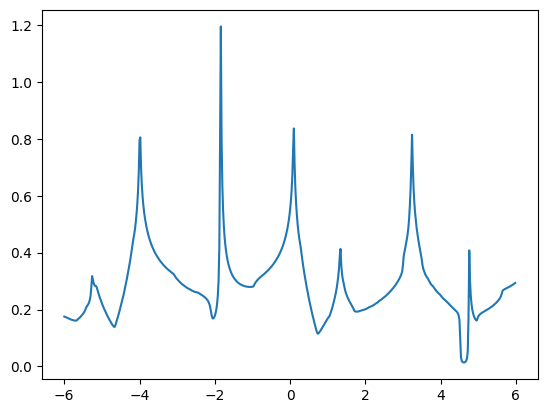

In [66]:
plt.plot(omega, DOS)

plt.show()